In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import os
from matplotlib.cm import get_cmap
from scipy.stats import truncnorm, qmc
from tqdm import tqdm
import scipy.stats as stats
from scipy.stats import wasserstein_distance, ks_2samp
import seaborn as sns
from itertools import product
import random
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import hamming_loss
from sklearn.model_selection import train_test_split
import scipy.stats as stats
from scipy.stats import uniform
from matplotlib import colormaps
import matplotlib.colors as mcolors
import ili
from ili.dataloaders import NumpyLoader
from ili.inference import InferenceRunner
from ili.validation.metrics import PosteriorCoverage, PlotSinglePosterior
from torch.distributions import Distribution, Uniform, HalfNormal
from torch.distributions.utils import broadcast_all
import math
from ili.utils.distributions_pt import CustomIndependent, IndependentTruncatedNormal
import itertools

import symbolic_pofk.syren_new as syren_new
import symbolic_pofk.linear as linear

# Device configuration
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Device:', device)
sns.set(style="whitegrid", context="paper")

/home/x-ctirapongpra/.conda/envs/2024.02-py311/tailed-uniform/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Device: cpu


In [2]:
class TailedNormal(Distribution):
    arg_constraints = {
        'a': torch.distributions.constraints.real,
        'b': torch.distributions.constraints.dependent,
        'sigma': torch.distributions.constraints.positive,
    }
    support = torch.distributions.constraints.real
    has_rsample = False

    def __init__(self, a, b, sigma, validate_args=None):
        self.a, self.b, self.sigma = broadcast_all(a, b, sigma)
        if torch.any(self.a >= self.b):
            raise ValueError("`a` must be less than `b`.")
        
        self.Z = math.sqrt(2 * math.pi) * self.sigma + (self.b - self.a)
        self.A = math.sqrt(2 * math.pi) * self.sigma / self.Z
        self.B = (self.b - self.a) / self.Z

        self.halfnormal = HalfNormal(self.sigma)

        super().__init__(batch_shape=self.a.size(), validate_args=validate_args)

    def log_prob(self, x):
        x, a, b, sigma = broadcast_all(x, self.a, self.b, self.sigma)

        logA = torch.log(self.A.to(dtype=x.dtype, device=x.device))
        logB = torch.log(self.B.to(dtype=x.dtype, device=x.device))
        log_uniform = logB - torch.log(b - a)

        # left: x <= a => z = a - x
        z_left = torch.abs(a - x)
        log_halfnorm_left = self.halfnormal.log_prob(z_left) + logA - math.log(2.0)

        # right: x >= b => z = x - b
        z_right = torch.abs(x - b)
        log_halfnorm_right = self.halfnormal.log_prob(z_right) + logA - math.log(2.0)

        return torch.where(x <= a, log_halfnorm_left,
               torch.where(x >= b, log_halfnorm_right,
               log_uniform))

    def cdf(self, x):
        x, a, b, sigma = broadcast_all(x, self.a, self.b, self.sigma)
        sqrt2 = math.sqrt(2.0)

        def Phi(z):  # Standard Normal CDF
            return 0.5 * (1 + torch.erf(z / sqrt2))

        left_cdf = self.A * Phi((x - a) / sigma)
        center_cdf = 0.5 * self.A + self.B * (x - a) / (b - a)
        right_cdf = self.B + self.A * Phi((x - b) / sigma)

        return torch.where(x <= a, left_cdf,
               torch.where(x >= b, right_cdf,
               center_cdf))
    
    def icdf(self, u):
        # Helper function for the Inverse Standard Normal CDF
        def inv_Phi(p):
            # Clamping p to avoid NaNs from erfinv at the boundaries 0 and 1
            p_clamped = torch.clamp(p, 1e-9, 1.0 - 1e-9)
            return math.sqrt(2.0) * torch.erfinv(2.0 * p_clamped - 1.0)

        # Thresholds dividing the distribution regions
        thresh_left = 0.5 * self.A
        thresh_right = 1.0 - 0.5 * self.A

        u_left_norm = u / self.A
        left_tail = self.a + self.sigma * inv_Phi(u_left_norm)

        u_right_norm = (u - self.B) / self.A
        right_tail = self.b + self.sigma * inv_Phi(u_right_norm)

        u_middle_norm = (u - thresh_left) / self.B
        middle = self.a + u_middle_norm * (self.b - self.a)

        return torch.where(u < thresh_left, left_tail,
                           torch.where(u > thresh_right, right_tail, middle))
        

    def sample(self, sample_shape=torch.Size()):
        u = torch.rand(sample_shape + self.a.shape, device=self.a.device)
        thresh_left = 0.5 * self.A
        thresh_right = 1.0 - 0.5 * self.A

        left_tail = self.a - self.halfnormal.sample(sample_shape)
        right_tail = self.b + self.halfnormal.sample(sample_shape)

        x_middle = self.a + (u - thresh_left) * (self.b - self.a) / self.B

        return torch.where(u < thresh_left, left_tail,
               torch.where(u > thresh_right, right_tail,
               x_middle))
    
    def sample_lhs(self, n_samples):
        """Sample using Latin Hypercube Sampling"""
        # Generate LHS samples in [0,1]^d
        sampler = qmc.LatinHypercube(d=len(self.a.flatten()), seed=42)
        u_samples = sampler.random(n_samples)
        u_tensor = torch.tensor(u_samples, dtype=torch.float32, device=self.a.device)
        
        # Transform using inverse CDF
        return self.icdf(u_tensor)

    def mean(self):
        return 0.5 * (self.a + self.b)

IndependentTailedNormal = type('IndependentTailedNormal', (CustomIndependent,), {'Distribution': TailedNormal})

In [3]:
# Fixed
L, N = 1000, 128
kf = 2*np.pi/L
knyq = np.pi*N/L
kedges = np.arange(0, knyq, kf)
kcenters = (kedges[:-1] + kedges[1:])/2
a = 1.0

def simulator(theta):
   """Simulator: theta -> P(k)"""
   Om, h = theta
   # Also fixed (for now)
   As = 2.105  # 10^9 A_s
   Ob = 0.02242 / h ** 2
   ns = 0.9665
   w0 = -1.0  
   wa = 0.0
   mnu = 0.0
   pk_syren_theory = syren_new.pnl_new_emulated(
         kcenters, As, Om, Ob, h, ns, mnu, w0, wa, a=a
      )

   var_single = np.abs(pk_syren_theory)**2
   Nk = L**3 * kcenters**2 * kf / (2*np.pi**2)
   var_mode = var_single * 2 / Nk
   std_mode = np.sqrt(var_mode)

   pk_w_noise = pk_syren_theory + std_mode*np.random.randn(*pk_syren_theory.shape)
   return pk_w_noise

In [4]:
def sample_uniform_lhs(n_samples, param_ranges, device=device):
    """
    Generate uniform samples using Latin Hypercube Sampling
    with different ranges per parameter.

    Args:
        n_samples (int): number of samples
        param_ranges (list of tuples): [(low1, high1), (low2, high2), ...]
        device (str): 'cpu' or 'cuda'
    """
    dim = len(param_ranges)
    sampler = qmc.LatinHypercube(d=dim, seed=42)
    u_samples = sampler.random(n_samples)  # in [0,1]^dim

    # scale each column to its parameter range
    samples = np.zeros_like(u_samples)
    for i, (low, high) in enumerate(param_ranges):
        samples[:, i] = low + (high - low) * u_samples[:, i]

    return torch.tensor(samples, dtype=torch.float32, device=device)


In [5]:
n_simulations = 10000

# Parameter ranges [Om, h]
param_1_range = (0.24, 0.40)   # Om
param_2_range = (0.61, 0.73)    # h
param_ranges = [param_1_range, param_2_range]

param_1_width = param_1_range[1] - param_1_range[0]
param_2_width = param_2_range[1] - param_2_range[0]

# Scale sigma relative to parameter ranges
sigma_scale = 0.1
sigmas = [sigma_scale * (high - low) for low, high in param_ranges]

# Prior
prior = ili.utils.IndependentNormal(
   loc=[param_1_range[0] + param_1_width/2, param_2_range[0] + param_2_width/2],
   scale=sigmas, 
   device=device
)

# Create proposal distributions
proposal_old = ili.utils.Uniform(
   low=[param_1_range[0], param_2_range[0]], 
   high=[param_1_range[1], param_2_range[1]], 
   device=device
)

proposal_new = TailedNormal(
   a=torch.tensor([param_1_range[0], param_2_range[0]], dtype=torch.float32),
   b=torch.tensor([param_1_range[1], param_2_range[1]], dtype=torch.float32),
   sigma=torch.tensor([sigmas[0], sigmas[1]], dtype=torch.float32),
)

In [6]:
# Sample from proposals
theta_old = sample_uniform_lhs(n_samples=n_simulations, param_ranges = param_ranges)
theta = proposal_new.sample_lhs(n_simulations)

# Run simulations
x_old = np.array([simulator(theta_old[i].numpy()) for i in range(n_simulations)])
x = np.array([simulator(theta[i].numpy()) for i in range(n_simulations)])

print(f"Uniform proposal parameter range: Om={theta_old[:, 0].min():.3f}-{theta_old[:, 0].max():.3f}, h={theta_old[:, 1].min():.3f}-{theta_old[:, 1].max():.3f}")
print(f"TailedNormal proposal parameter range: Om={theta[:, 0].min():.3f}-{theta[:, 0].max():.3f}, h={theta[:, 1].min():.3f}-{theta[:, 1].max():.3f}")

Uniform proposal parameter range: Om=0.240-0.400, h=0.610-0.730
TailedNormal proposal parameter range: Om=0.182-0.462, h=0.565-0.772


Saved plot: sci-2-dim-figures/example-samples.png


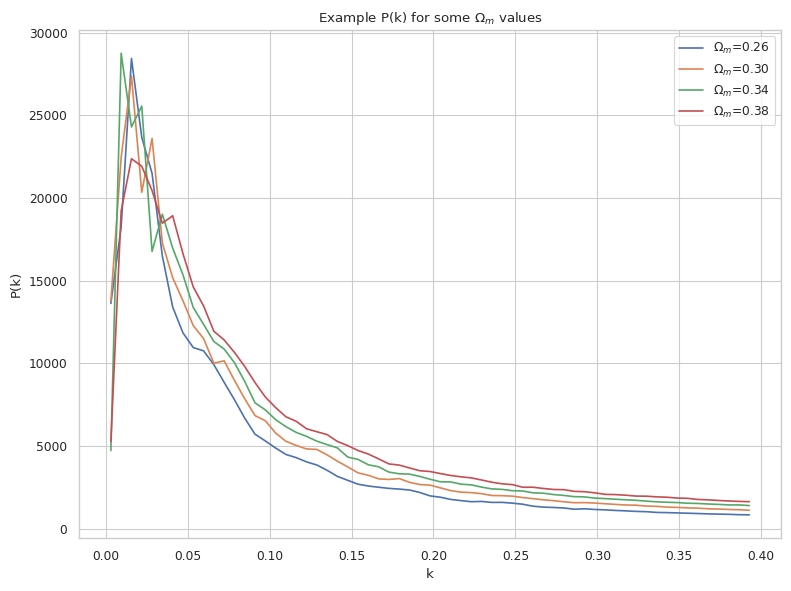

In [7]:
# Plot example simulations
omega_m_values = [0.26, 0.30, 0.34, 0.38]
h_fixed = 0.7

plt.figure(figsize=(8, 6))
for Om in omega_m_values:
    pk = simulator([Om, h_fixed])
    plt.plot(kcenters, pk, label=f'$\Omega_m$={Om:.2f}')

plt.xlabel('k')
plt.ylabel('P(k)')
plt.title('Example P(k) for some $\Omega_m$ values')
plt.legend()
plt.tight_layout()
os.makedirs('sci-2-dim-figures', exist_ok=True)
filename = f'sci-2-dim-figures/example-samples.png'
plt.savefig(filename, dpi=300, bbox_inches='tight')
print(f"Saved plot: {filename}")
plt.show()

Saved plot: sci-2-dim-figures/parameter-space.png


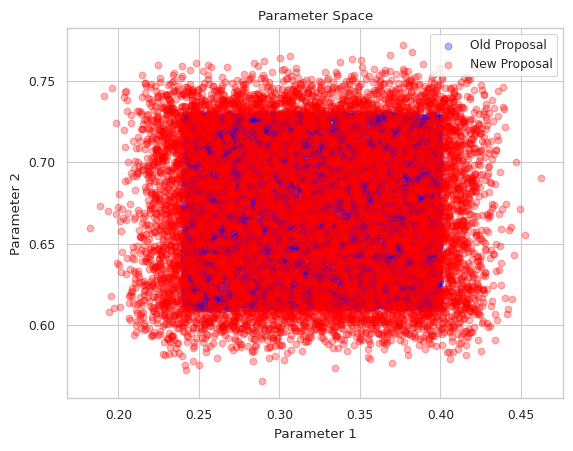

In [8]:
plt.scatter(theta_old[:, 0].cpu(), theta_old[:, 1].cpu(), c='blue', label='Old Proposal', alpha=0.3)
plt.scatter(theta[:, 0].cpu(), theta[:, 1].cpu(), c='red', label='New Proposal', alpha=0.3)
plt.xlabel('Parameter 1')
plt.ylabel('Parameter 2')
plt.title('Parameter Space')
plt.legend()

filename = f'sci-2-dim-figures/parameter-space.png'
plt.savefig(filename, dpi=300, bbox_inches='tight')
print(f"Saved plot: {filename}")

Saved plot: sci-2-dim-figures/parameter-space-posterior.png


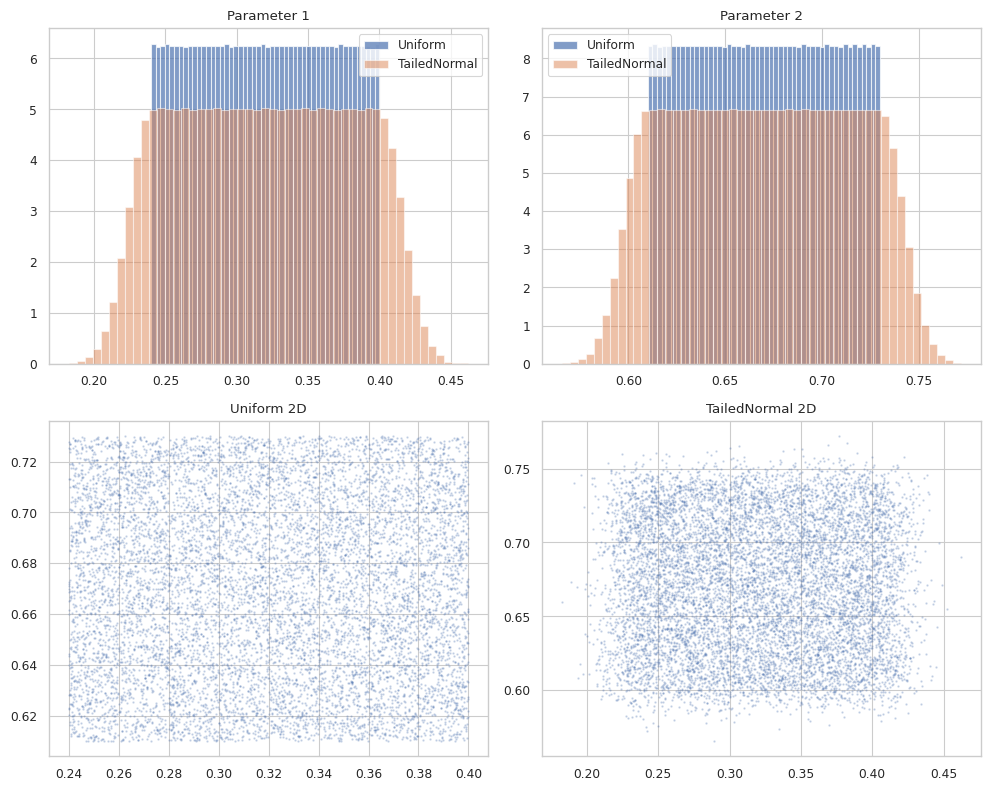

In [9]:
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

# Parameter 1
axes[0,0].hist(theta_old[:, 0], bins=50, alpha=0.7, label='Uniform', density=True)
axes[0,0].hist(theta[:, 0], bins=50, alpha=0.5, label='TailedNormal', density=True)
axes[0,0].set_title('Parameter 1')
axes[0,0].legend()

# Parameter 2
axes[0,1].hist(theta_old[:, 1], bins=50, alpha=0.7, label='Uniform', density=True)
axes[0,1].hist(theta[:, 1], bins=50, alpha=0.5, label='TailedNormal', density=True)
axes[0,1].set_title('Parameter 2')
axes[0,1].legend()

# 2D scatter plots
axes[1,0].scatter(theta_old[:, 0], theta_old[:, 1], alpha=0.2, s=1)
axes[1,0].set_title('Uniform 2D')

axes[1,1].scatter(theta[:, 0], theta[:, 1], alpha=0.2, s=1)
axes[1,1].set_title('TailedNormal 2D')

plt.tight_layout()

filename = f'sci-2-dim-figures/parameter-space-posterior.png'
plt.savefig(filename, bbox_inches='tight')
print(f"Saved plot: {filename}")

In [10]:
# Create dataloaders
loader_old = NumpyLoader(x=x_old, theta=theta_old)
loader = NumpyLoader(x=x, theta=theta)

# Instantiate neural networks for ensemble
nets = [
    ili.utils.load_nde_sbi(engine='NPE', model='maf', hidden_features=16, num_transforms=5,),
    ili.utils.load_nde_sbi(engine='NPE', model='made', hidden_features=16, num_transforms=5)
]

nets_nle = [
    ili.utils.load_nde_sbi(engine='NLE', model='maf', hidden_features=16, num_transforms=5,),
    ili.utils.load_nde_sbi(engine='NLE', model='made', hidden_features=16, num_transforms=5)
]

# Define training arguments
train_args = {
   'training_batch_size': 64,
   'learning_rate': 5e-5
}

os.makedirs('sci-2-dim-models', exist_ok=True)

# Initialize the trainers
runner_old = InferenceRunner.load(
   backend='sbi',
   engine='NPE',
   prior=prior,
   nets=nets,
   device=device,
   train_args=train_args,
   proposal=proposal_old,
   out_dir='sci-2-dim-models/uniform_power'
)

runner = InferenceRunner.load(
   backend='sbi',
   engine='NPE',
   prior=prior,
   nets=nets,
   device=device,
   train_args=train_args,
   proposal=proposal_new,
   out_dir='sci-2-dim-models/tailed_power'
)

runner_nle = InferenceRunner.load(
    backend='sbi',
    engine='NLE',
    prior=prior,  # Use the same prior
    nets=nets_nle,
    device=device,
    train_args=train_args,
    proposal=proposal_old,
    out_dir='sci-2-dim-models/nle_power'
)

In [11]:
posterior_ensemble_old, summaries_old = runner_old(loader=loader_old)
posterior_ensemble, summaries = runner(loader=loader)

INFO:root:MODEL INFERENCE CLASS: NPE
/home/x-ctirapongpra/.conda/envs/2024.02-py311/tailed-uniform/lib/python3.10/site-packages/sbi/inference/snpe/snpe_base.py:601: UserWarning: The proposal you passed is neither the prior nor a `NeuralPosterior` object. If you are an expert user and did so for research purposes, this is fine. If not, you might be doing something wrong: feel free to create an issue on Github.
  warn(
INFO:root:Training model 1 / 2.


Using SNPE-C with atomic loss
Using SNPE-C with atomic loss
 Training neural network. Epochs trained: 278

INFO:root:Training model 2 / 2.


 Neural network successfully converged after 279 epochs.Using SNPE-C with atomic loss
Using SNPE-C with atomic loss
 Training neural network. Epochs trained: 392

/home/x-ctirapongpra/.conda/envs/2024.02-py311/tailed-uniform/lib/python3.10/site-packages/sbi/utils/posterior_ensemble.py:142: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self._weights = torch.tensor(weights) / sum(weights)
INFO:root:It took 725.9625539779663 seconds to train models.
INFO:root:Saving model to sci-2-dim-models/uniform_power
INFO:root:MODEL INFERENCE CLASS: NPE


 Neural network successfully converged after 393 epochs.

/home/x-ctirapongpra/.conda/envs/2024.02-py311/tailed-uniform/lib/python3.10/site-packages/sbi/inference/snpe/snpe_base.py:601: UserWarning: The proposal you passed is neither the prior nor a `NeuralPosterior` object. If you are an expert user and did so for research purposes, this is fine. If not, you might be doing something wrong: feel free to create an issue on Github.
  warn(
INFO:root:Training model 1 / 2.


Using SNPE-C with atomic loss
Using SNPE-C with atomic loss
 Training neural network. Epochs trained: 533

INFO:root:Training model 2 / 2.


 Neural network successfully converged after 534 epochs.Using SNPE-C with atomic loss
Using SNPE-C with atomic loss
 Training neural network. Epochs trained: 356

INFO:root:It took 994.0838532447815 seconds to train models.
INFO:root:Saving model to sci-2-dim-models/tailed_power


 Neural network successfully converged after 357 epochs.

In [12]:
posterior_ensemble_nle, summaries_nle = runner_nle(loader=loader)

INFO:root:MODEL INFERENCE CLASS: NLE
INFO:root:Training model 1 / 2.


 Training neural network. Epochs trained: 305

INFO:root:Training model 2 / 2.


 Training neural network. Epochs trained: 343306 epochs.

INFO:root:It took 1112.6914949417114 seconds to train models.
INFO:root:Saving model to sci-2-dim-models/nle_power


 Neural network successfully converged after 344 epochs.

Saved plot: sci-2-dim-figures/train-and-val.png


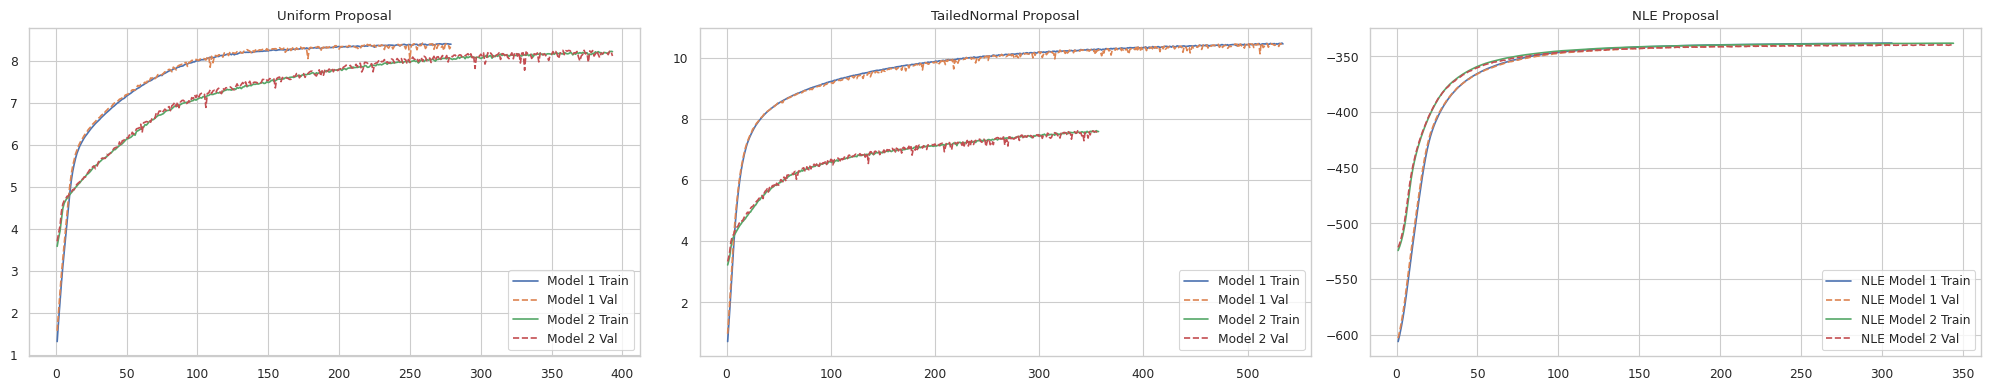

In [14]:
fig, axes = plt.subplots(1, 3, figsize=(20, 4))

# Uniform proposal
for i, summary in enumerate(summaries_old):
   train_logprob = -1.0 * np.array(summary['training_loss'])
   val_logprob = -1.0 * np.array(summary['validation_loss'])
   epochs = np.arange(1, len(train_logprob) + 1)
   axes[0].plot(epochs, train_logprob, label=f"Model {i+1} Train")
   axes[0].plot(epochs, val_logprob, '--', label=f"Model {i+1} Val")
axes[0].set_title('Uniform Proposal')
axes[0].legend()

# TailedNormal proposal  
for i, summary in enumerate(summaries):
   train_logprob = -1.0 * np.array(summary['training_loss'])
   val_logprob = -1.0 * np.array(summary['validation_loss'])
   epochs = np.arange(1, len(train_logprob) + 1)
   axes[1].plot(epochs, train_logprob, label=f"Model {i+1} Train")
   axes[1].plot(epochs, val_logprob, '--', label=f"Model {i+1} Val")
axes[1].set_title('TailedNormal Proposal')
axes[1].legend()

# NLE proposal

for i, summary in enumerate(summaries_nle):
    train_logprob = -1.0 * np.array(summary['training_loss'])
    val_logprob = -1.0 * np.array(summary['validation_loss'])
    epochs = np.arange(1, len(train_logprob) + 1)
    axes[2].plot(epochs, train_logprob, label=f"NLE Model {i+1} Train")
    axes[2].plot(epochs, val_logprob, '--', label=f"NLE Model {i+1} Val")
axes[2].set_title('NLE Proposal')
axes[2].legend()
plt.tight_layout()
filename = f'sci-2-dim-figures/train-and-val.png'
plt.savefig(filename, dpi=300, bbox_inches='tight')
print(f"Saved plot: {filename}")
plt.show()

Running vectorized MCMC with 20 chains: 100%|█████████▉| 23600/23700 [01:25<00:00, 277.49it/s]


Saved plot: sci-2-dim-figures/histogram.png


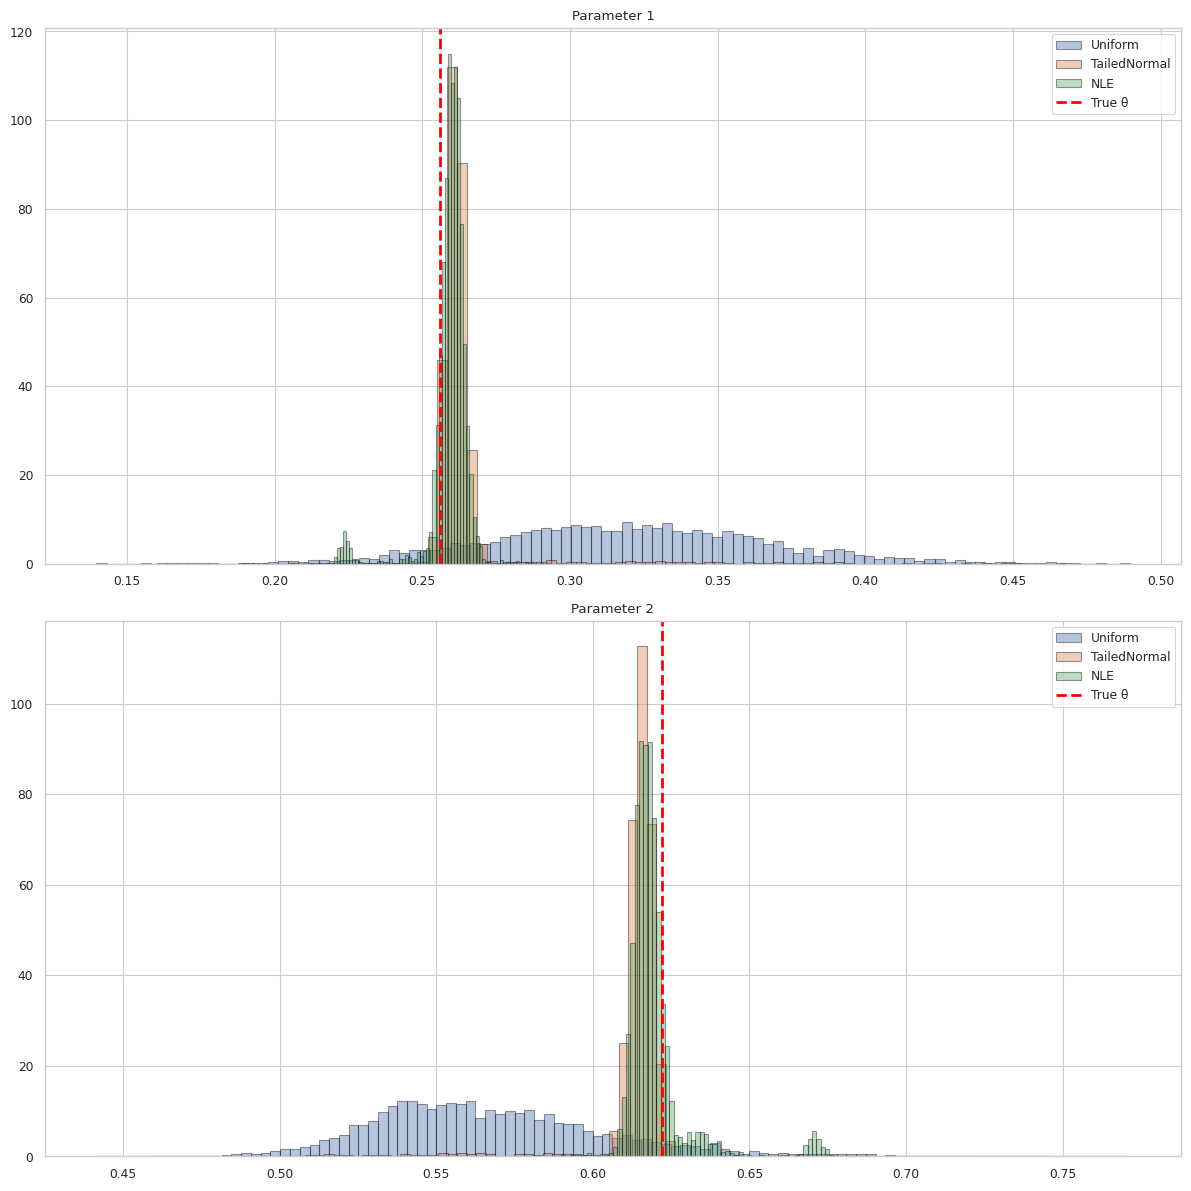

In [17]:
theta_true_edge = np.array([
    param_1_range[0] + 0.1 * param_1_width,
    param_2_range[0] + 0.1 * param_2_width
])

n_posterior_samples = 1000
x_obs_edge = simulator(theta_true_edge)

samples_uniform = posterior_ensemble_old.sample((n_posterior_samples,), x_obs_edge).cpu().numpy()
samples_tailed = posterior_ensemble.sample((n_posterior_samples,), x_obs_edge).cpu().numpy()
samples_nle = posterior_ensemble_nle.sample(
    (n_posterior_samples,), x_obs_edge, 
    method='slice_np_vectorized', num_chains=20
).detach().cpu().numpy()

fig, axes = plt.subplots(2, 1, figsize=(12, 12))

methods = ['Uniform', 'TailedNormal', 'NLE']
samples_list = [samples_uniform, samples_tailed, samples_nle]

for i, param in enumerate(['Parameter 1', 'Parameter 2']):
   for method, samples in zip(methods, samples_list):
       axes[i].hist(samples[:, i], bins=100, alpha=0.4, density=True, label=method, edgecolor='black')
   axes[i].axvline(theta_true_edge[i], color='red', linestyle='--', linewidth=2, label='True θ')
   axes[i].set_title(f'{param}')
   axes[i].legend()

plt.tight_layout()
os.makedirs('sci-2-dim-figures', exist_ok=True)
filename = f'sci-2-dim-figures/histogram.png'
plt.savefig(filename, bbox_inches='tight')
print(f"Saved plot: {filename}")
plt.show()